# Recurrent Neural Network

## 1) Importing the packages and data pre-processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

df_training = pd.read_csv('Google_Stock_Price_Train.csv')

df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [26]:
print(df_training.head())
print(df_training.tail())

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
            Date    Open    High     Low   Close     Volume
1253  12/23/2016  790.90  792.74  787.28  789.91    623,400
1254  12/27/2016  790.68  797.86  787.66  791.55    789,100
1255  12/28/2016  793.70  794.23  783.20  785.05  1,153,800
1256  12/29/2016  783.33  785.93  778.92  782.79    744,300
1257  12/30/2016  782.75  782.78  770.41  771.82  1,770,000


We have no null values, and the data from january 3rd of 2012, to december 30th of 2016

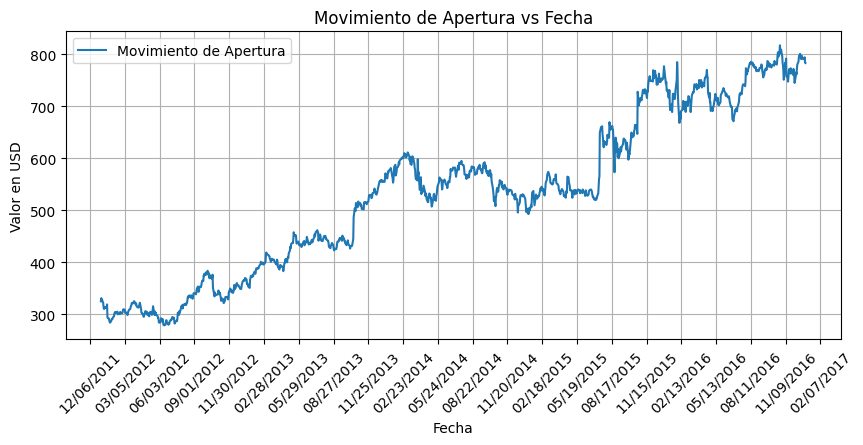

In [2]:
import matplotlib.dates as mdates

ploting_df = df_training.copy()
ploting_df['Date'] = pd.to_datetime(ploting_df['Date'], format = '%m/%d/%Y')

plt.figure(figsize=(10,4))
plt.plot(ploting_df['Date'], ploting_df['Open'], label = 'Movimiento de Apertura')

# Adjust X axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=90))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.xticks(rotation = 45)

plt.title('Movimiento de Apertura vs Fecha')
plt.xlabel('Fecha')
plt.ylabel('Valor en USD')
plt.legend()
plt.grid(True)
plt.show()

## 2) Adjust format and keep important information

First, we want to predice the OPEN value, (we could've chose other values but in this case we will go for that one)

In [3]:
train_set = df_training['Open'].to_frame().values

# As always, we need to fit the data with a Scaler. In this case, we are going to use the Min Max Scaler, which performs a Normalization on the data.
# The reason, is that is highly recommended to use this tipe of fitting before using an RNN.

# The values have to be normalized. This is a Normalization since the formula applied is: 

# X_norm = (X_real - min) / (max-min)

# Where "min" is the the minimun value of the X set and max is the max value of the X set.

scaler = MinMaxScaler(feature_range = (0,1)) # The values that are going to come out of the scaler are always between 0 and 1

train_set_scaled = scaler.fit_transform(train_set)

## 3) Fit the data and variables that the model is going to use

We have to define, how many "t" times the model is going to see to the past. Remember that each value P is actualy a function in time
where X(t) = P_t, and the model is going to try to ajust this function X(t) as good as it can.

In this case, we are going to use 3 months in the past (you are actually have to try different values to see which one fits the best).

In [22]:
#We create the lists that are going to form our array
X_train = []
Y_train = []

#Since we are going to use the 90 days in the past to predict the 91st day value, we have to start in the day number 91.

for i in range(90, len(train_set_scaled)):
    X_train.append(train_set_scaled[i-90:i, 0]) # Note that the array that we are adding is a 1D array
    Y_train.append(train_set_scaled[i,0]) #Note that here we use 0 to spicfy  the column as a good practice, since train_set_scaled only has 1 column

# Now we are going to turn the lists into arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# For the recurrent Layer Input we need the following parameteres (batch_size, timesteps, input_dim)
# Where batch_size is the number of rows and timesteps is the t = 90 that we defined before (Number of columns). 
# On the other hand input_dim is the number of variables that we are using to predict the value P_t. In this case we are only using the opening value
# of the Google stock. In another jupter notebook I'll show you how would it be using 2 or more indicators (like the closing value)
print(X_train.shape)
X_train = np.reshape(X_train, (len(X_train), X_train.shape[1], 1))
print(X_train.shape)


(1168, 90)
(1168, 90, 1)


## 4) Build the Neural Network

In [24]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input

nn = Sequential() #The NN is the SEQUENCE of layers

nn.add(Input(shape=(X_train.shape[1], X_train.shape[2]))) #The pre-define the input shape so we avoid any problems with the LSTM layer. it identifies the rows by itself, we only need to give to the model the timesteps (columns) and the indicators (1)

# First Round of LSTM LAYERS

nn.add(LSTM(units = 90, 
            return_sequences = True
            )) #LSTM need at least 2 parameteres. 1) Number of Neurons, 2) Return Sequence
                        # 1) When choosing a Number of Neurons, you can choose how many you want, but I like to start trying with the amoint of t values
                        # 2) This parameters indicates that we are going to add another LSTM layer after this one because we are going to build a stacked NN

nn.add(Dropout(0.2))   # We have to define the amount of neurons that we are going to drop in the layers to do the regularization. (Avoid overfitting). 
                        # We are going to ignore 20% of the neurons during the back and front propagation in the training.

# Now we are just going to double the same 2 layers added before (SECOND ROUND OF LAYERs)
nn.add(LSTM(units = 90, return_sequences = True ))
nn.add(Dropout(0.2))

# Now we are just going to double the same 2 layers added before (THIRD ROUND OF LAYERS)
nn.add(LSTM(units = 90, return_sequences = True ))
nn.add(Dropout(0.2))

# Now we are just going to double the same 2 layers added before (THIRD ROUND OF LAYERS). But since this is the last round of LSTM layers, we
# are settingg "return_sequences" to false
nn.add(LSTM(units = 90, return_sequences = False )) #NOTE: <----HERE RETURN SQUENCE IS FALSE
nn.add(Dropout(0.2))

# Output Layer

nn.add(Dense(units = 1)) # Since we are predicting a continous value, we don't need to use the activation function that we usually do


## 5) Train the Neural Network
First we need to compile the the NN. It meas, defining "HOW" it is going to learn. In order to do that we need to define AT LEAST 2 parameters.

a) Optimizer: Basically it is the algorithm that is going to be used. Some examples are SGD, RMSprop, or ADAM. (Usually for RNN, the RMSProp optimized is the most recommended one)

b) Loss Function:  It is basically the metric that is going to define how good is the model performance.

c) [OPTIONAL AND RECOMMENDED] Metrics: It is a list of metric that are going to be evaluated and reported during the training part.

In [25]:
from keras.optimizers import RMSprop


nn.compile(optimizer= RMSprop(learning_rate=0.001), loss='mean_squared_error', metrics=['mae', 'mse'])
                                                # 1) Optimizer: RMSprop) we are going to use the Root Mean Squared Propagation. It is like a variation of gradient descent but with steroid hahahaha. 
                                                #2) Loss Function:  mean_squared_error, which makes more sense for a continuous values predictions.
                                                #3) Metrics: for this instance we are using mae and mse, but this is actually OPTIONAL


nn.fit(X_train, Y_train, batch_size = 32, epochs = 200)

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 0.1135 - mae: 0.2279 - mse: 0.1135
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0202 - mae: 0.1062 - mse: 0.0202
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0184 - mae: 0.0986 - mse: 0.0184
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0116 - mae: 0.0769 - mse: 0.0116
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0105 - mae: 0.0769 - mse: 0.0105
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0080 - mae: 0.0651 - mse: 0.0080
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0087 - mae: 0.0704 - mse: 0.0087
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.0082 - mae: 0.0682 - mse: 0.0082
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.0070 - mae: 0.0627 - mse: 0.0070
Epoch 10/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 0.0080 - mae: 0.0685 - mse: 0.0080
Epoch 11/200
37/37 ━━━━━━━━━━━━━━━━━━━

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


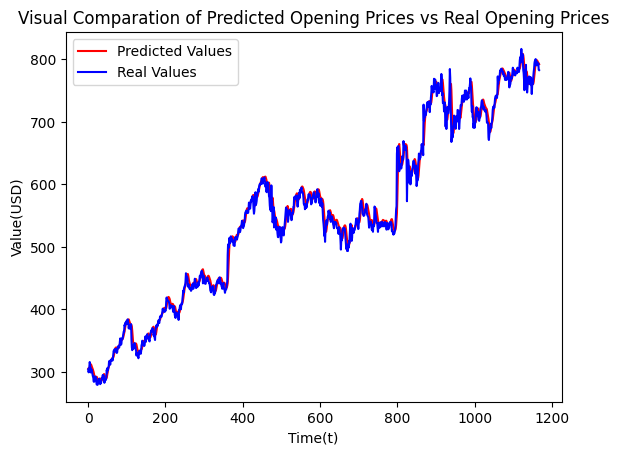

In [74]:
training_prediction = nn.predict(X_train)
training_reaL_values = Y_train.reshape(-1, 1)

training_prediction = scaler.inverse_transform(training_prediction)
training_reaL_values = scaler.inverse_transform(training_reaL_values)

plt.plot(training_prediction, color = 'red', label = 'Predicted Values')
plt.plot(training_reaL_values, color = 'blue', label = 'Real Values')
plt.title('Visual Comparation of Predicted Opening Prices vs Real Opening Prices')
plt.xlabel('Time(t)')
plt.ylabel('Value(USD)')
plt.legend()
plt.show()

# 6) Test the NN

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

df_testing = pd.read_csv('Google_Stock_Price_Test.csv')

print(df_testing.info())
print(df_testing.head())
print(df_testing.tail())

# Remember that: In order to predict t = 0, we need the previous 90 values, which are part of the training set. Therefore, we are going to 
# concatenate the training and testing dataframes

df_training_to_concatenate = df_training.tail(90)

df_testing_concatenated = pd.concat((df_training_to_concatenate, df_testing), axis = 0).reset_index()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB
None
       Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400
         Date    Open    High     Low   Close     Volume
15  1/25/2017  829.62  835.77  825.06  835.67  1,494,500
16  1/26/2017  837.81  838.00  827.01  832.15  2,973,900
17  1/27/2017  834.71  841.95  820.44  823.3

In [44]:
df_testing_concatenated.tail(25)

,index,Date,Open,High,Low,Close,Volume
85,1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
86,1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
87,1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
88,1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"
89,1257,12/30/2016,782.75,782.78,770.41,771.82,"1,770,000"
90,0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
91,1,1/4/2017,788.36,791.34,783.16,786.9,"1,073,000"
92,2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
93,3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
94,4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [53]:
test_set = df_testing_concatenated['Open'].to_frame().values
test_set_scaled = scaler.transform(test_set) # DON'T FORGET TO SCALED IT, but no usin fit_transform but just transform.

X_test = []
## We had 20 values in the testing set, and we added extra 90 at the beggining, which means now we have 110. We only want to predict the last 20.
# That means we have to go from i = 0 to i = 20, and taking 90 values lenght for each i value.
for i in range(0, len(test_set_scaled)-90):
    X_test.append(test_set_scaled[i:i+90,0])

# NOTE: IMPORTANT! This code only takes until the value of the row before the last one. Why doesn't it take take the last one too? 
# Because we want to predict the last row, however, we are not using it to make a prediction itself.

X_test = np.array(X_test)

print(X_test.shape)
X_test = np.reshape(X_test, (len(X_test), X_test.shape[1], 1)) # Don't forget to reshape
print(X_test.shape)

(20, 90)
(20, 90, 1)


In [77]:
y_predic_scaled = nn.predict(X_test)
y_predic = scaler.inverse_transform(y_predic_scaled) # PREDICTED VALUES
y_test = df_testing['Open'].to_frame().values # REAL VALUES

#Check some values
mae_test = mean_absolute_error(y_test, y_predic)
print('TESTING: Mean Absolute Error (MAE):', round(mae_test,1))
mae_training = mean_absolute_error(training_reaL_values, training_prediction)
print('TRAINING: Mean Absolute Error (MAE):', round(mae_training,1))


print("-----")


mse_test = mean_squared_error(y_test, y_predic)
print('TESTING: Mean Squared Error (MSE):', round(mse_test,1))
mse_training = mean_squared_error(training_reaL_values, training_prediction)
print('TRAINING: Mean Squared Error (MSE):', round(mse_training,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
TESTING: Mean Absolute Error (MAE): 9.5
TRAINING: Mean Absolute Error (MAE): 8.7
-----
TESTING: Mean Squared Error (MSE): 167.3
TRAINING: Mean Squared Error (MSE): 160.6


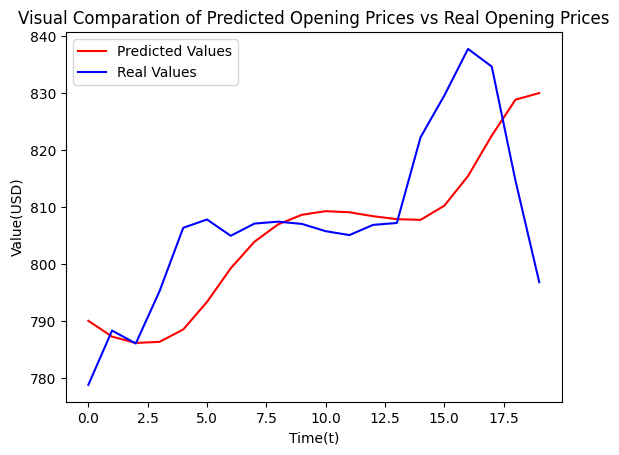

In [78]:
plt.plot(y_predic, color = 'red', label = 'Predicted Values')
plt.plot(y_test, color = 'blue', label = 'Real Values')
plt.title('Visual Comparation of Predicted Opening Prices vs Real Opening Prices')
plt.xlabel('Time(t)')
plt.ylabel('Value(USD)')
plt.legend()
plt.show()

## 7) Comments

If we look close, the model seems to follow the pattern but it does it a couple of days behind. On the other hand, we can see that the model has lower MSE and MAE error with the training set, which suggets that the NN might be OVERFITTED. 

Followed steps might include: 
- Methods to reduce Overfitting
- Tunning of Hyperparameters for better perfomermance
- Trying different types of loss function_